# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions
from trialexp.process.group_analysis.plot_utils import plot_group_average, plot_subject_average, plot_subject_comparison

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [2]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'US_delay_ms'], param_extract_method='tail')
df_session_info['hold_time_required_ms']=df_session_info['hold_time_required_ms'].astype(float)
df_session_info['US_delay_ms'] = df_session_info['US_delay_ms'].astype(float)

## Filter data based on a pre-definied list

In [3]:
good_session_list = pd.read_csv('good_session_DA.txt')
df_sel = df_session_info[df_session_info.session_id.isin(good_session_list.session_id)]
# df_sel = df_sel[df_sel.animal_id=='kms058']
df_sel.sort_values(['animal_id','expt_datetime'])

,animal_id,expt_datetime,session_id,task_name,path,session_no,US_delay_ms,hold_time_required_ms
270,JC317L,2022-12-05 17:23:59,JC317L-2022-12-05-172359,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,13.0,500.0,1000.0
347,JC318L,2022-12-05 17:17:08,JC318L-2022-12-05-171708,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,12.0,500.0,1000.0
334,JC318L,2022-12-06 17:11:08,JC318L-2022-12-06-171108,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,13.0,500.0,1000.0
172,kms058,2023-03-07 10:43:32,kms058-2023-03-07-104332,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,15.0,500.0,1000.0
400,kms058,2023-03-09 10:47:59,kms058-2023-03-09-104759,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,16.0,500.0,1000.0
159,kms058,2023-03-10 10:17:10,kms058-2023-03-10-101710,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,17.0,500.0,1000.0
426,kms058,2023-03-13 10:19:15,kms058-2023-03-13-101915,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,18.0,500.0,1000.0
213,kms058,2023-03-18 17:10:32,kms058-2023-03-18-171032,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,24.0,500.0,1000.0
371,kms058,2023-03-19 15:13:57,kms058-2023-03-19-151357,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,25.0,500.0,1000.0
377,kms058,2023-03-22 18:26:17,kms058-2023-03-22-182617,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,27.0,500.0,1000.0


In [4]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-04-01-180930/processed/xr_session.nc not found! skipping
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-03-17-114918
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-03-23-212344
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms064-2023-02-15-104438
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms062-2023-02-17-095947
[ 9 10 11] 2995 /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-10-101710
[ 9 10

In [5]:
ds_combined

<xarray.Dataset>
Dimensions:                           (trial_nb: 324, event_time: 500,
                                       session_id: 26)
Coordinates:
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 322 323 324
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
  * session_id                        (session_id) object 'kms058-2023-03-24-...
Data variables: (12/20)
    uid                               (session_id, trial_nb) object 'kms058_2...
    trigger                           (session_id, trial_nb) object 'hold_for...
    valid                             (session_id, trial_nb) float64 1.0 ... nan
    break_after_abort                 (session_id, trial_nb) float64 0.0 ... nan
    US_end_timer                      (session_id, trial_nb) float64 1.0 ... nan
    water_on                          (session_id, trial_nb) float64 1.0 ... nan
    ...                                ...
    success                           (session_id, trial_nb) float64 1.0 ... nan
    trial_outcome                     (session_id, trial_nb) object 'success'...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...

## Plot figures

In [6]:
ds_combined.event_time

<xarray.DataArray 'event_time' (event_time: 500)>
array([-1995, -1985, -1975, ...,  2975,  2985,  2995])
Coordinates:
  * event_time  (event_time) int64 -1995 -1985 -1975 -1965 ... 2975 2985 2995

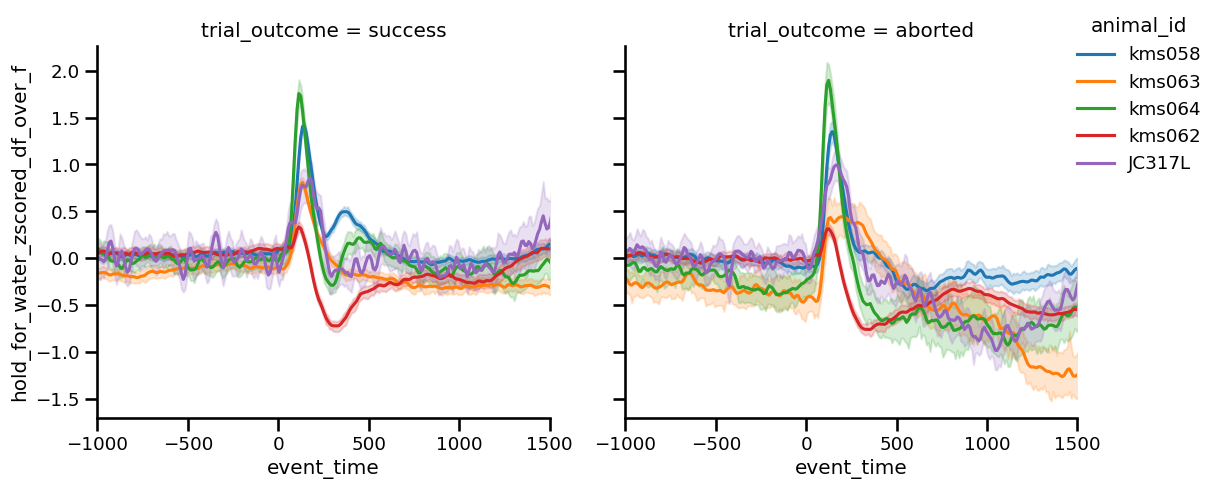

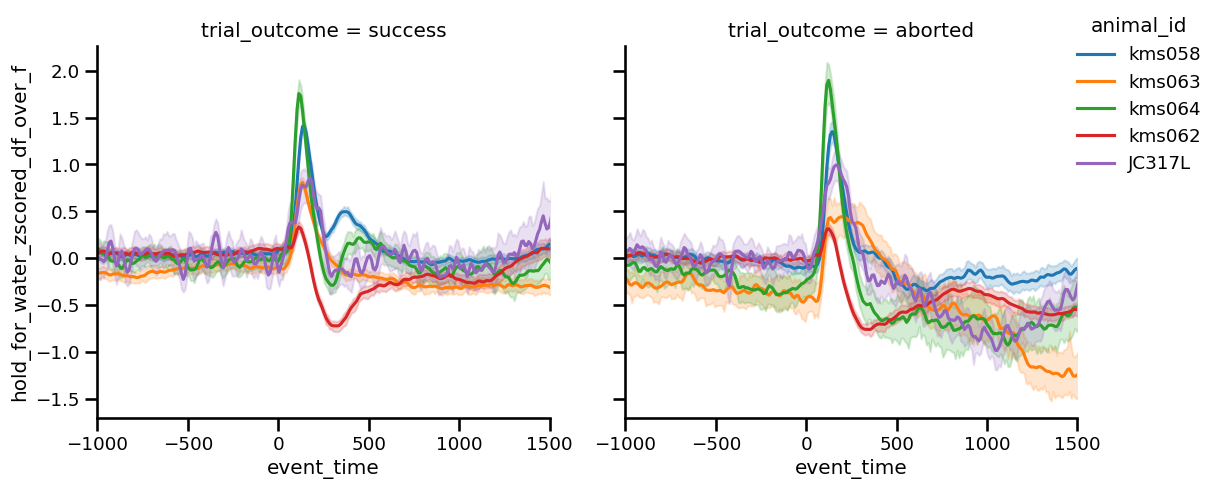

In [8]:
sns.set_context('talk',font_scale=0.8)

animal_id = df_sel[['animal_id','session_id','expt_datetime']]

plot_subject_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f')

/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:88: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = equal_subsample_trials(df2plot)


(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='event_time', ylabel='hold_for_water_zscored_df_over_f'>)

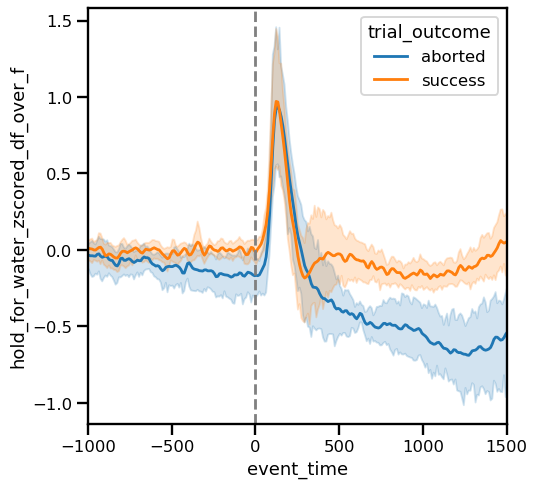

In [166]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f', 
                   average_method='mean_of_mean')

Using 188 trials for each subjects


(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='event_time', ylabel='hold_for_water_zscored_df_over_f'>)

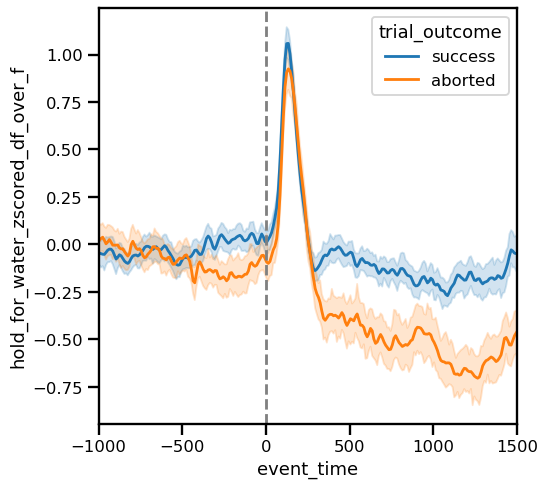

In [167]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f',
                   average_method='equal_subsample')

(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='event_time', ylabel='hold_for_water_zscored_df_over_f'>)

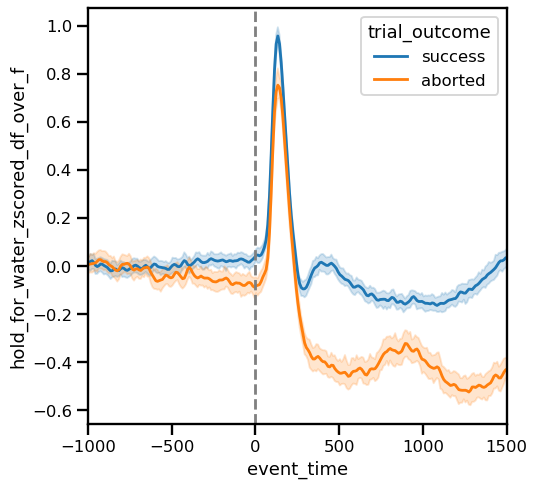

In [168]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f')

In [136]:
v = 'first_spout_zscored_df_over_f'
df2plot = ds_combined[[v, 'trial_outcome','session_id']].to_dataframe().reset_index()
df2plot = df2plot.merge(animal_id, on='session_id')
sel_trial_outcome = ['success', 'aborted']
df2plot = df2plot[df2plot.trial_outcome.isin(sel_trial_outcome)]
df2mean = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()

/tmp/ipykernel_2379288/2381279972.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2mean = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


<Axes: xlabel='event_time', ylabel='first_spout_zscored_df_over_f'>

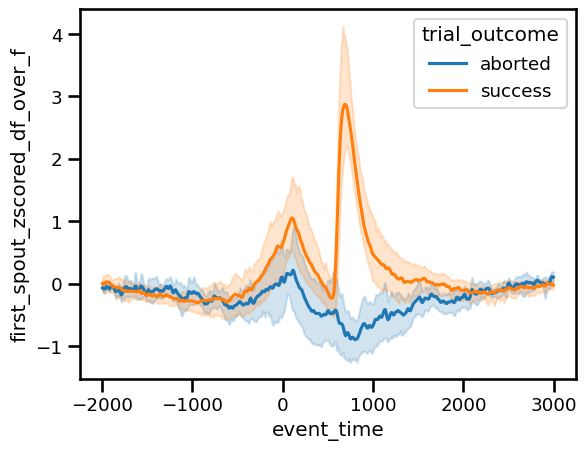

In [29]:
sns.lineplot(df2mean, x='event_time', y=v, hue='trial_outcome')

In [137]:
# subsampling

'''
1. groupby animal_id
2. dropna
3. sort by session_id and recode the trial_nb
4. calculate the total number of trial
5. sample random trial number
6. return the new dataframe
'''

def calculate_grand_trial_nb(df):
    # calcualte the grand trial nubmer across sessions

    df = df.sort_values('expt_datetime')
    
    # sort by expt date time and then cumsum over trial
    df = df.dropna()
    df = df[['animal_id','expt_datetime','trial_nb']]
    df_trial_nb = df.groupby(['animal_id','expt_datetime','trial_nb']).first().reset_index()
    df_trial_nb = df_trial_nb.sort_values(['expt_datetime','trial_nb']) # to be safe
    df_trial_nb['grand_trial_nb'] = 1
    df_trial_nb['grand_trial_nb'] = df_trial_nb.groupby('animal_id')['grand_trial_nb'].transform(pd.Series.cumsum)
    return df_trial_nb

df_trial_nb = calculate_grand_trial_nb(df2plot)

In [138]:
df2plot = df2plot.merge(df_trial_nb, on=['expt_datetime','trial_nb','animal_id'])
df2plot

,session_id,trial_nb,event_time,first_spout_zscored_df_over_f,trial_outcome,animal_id,expt_datetime,grand_trial_nb
0,kms058-2023-03-24-151254,1,-1995,2.560361,success,kms058,2023-03-24 15:12:54,1083
1,kms058-2023-03-24-151254,1,-1985,2.310296,success,kms058,2023-03-24 15:12:54,1083
2,kms058-2023-03-24-151254,1,-1975,2.029278,success,kms058,2023-03-24 15:12:54,1083
3,kms058-2023-03-24-151254,1,-1965,1.742456,success,kms058,2023-03-24 15:12:54,1083
4,kms058-2023-03-24-151254,1,-1955,1.598988,success,kms058,2023-03-24 15:12:54,1083
...,...,...,...,...,...,...,...,...
1637495,kms058-2023-03-13-101915,199,2955,-0.199614,success,kms058,2023-03-13 10:19:15,636
1637496,kms058-2023-03-13-101915,199,2965,-0.441477,success,kms058,2023-03-13 10:19:15,636
1637497,kms058-2023-03-13-101915,199,2975,-0.378478,success,kms058,2023-03-13 10:19:15,636
1637498,kms058-2023-03-13-101915,199,2985,-0.166634,success,kms058,2023-03-13 10:19:15,636


In [160]:
# Use the max no. trial of all animals as the sample
n_sample = df2plot.groupby('animal_id').grand_trial_nb.max().min()

def sample_trials(df_subject, n_sample):
    # randomly sample the trial of each subject
    if not 'grand_trial_nb' in df_subject:
        raise ValueError('grand_trial_nb must be in dataframe')
    
    max_trial_nb = df_subject.grand_trial_nb.max()
    sel_trials = np.random.choice(np.arange(max_trial_nb)+1, n_sample, replace=False)
    return df_subject[df_subject.grand_trial_nb.isin(sel_trials)]

df2 = df2plot.groupby('animal_id').apply(sample_trials, n_sample=n_sample).droplevel(0).reset_index()
df2

,index,session_id,trial_nb,event_time,first_spout_zscored_df_over_f,trial_outcome,animal_id,expt_datetime,grand_trial_nb
0,839500,JC317L-2022-12-05-172359,1,-1995,-0.167189,success,JC317L,2022-12-05 17:23:59,1
1,839501,JC317L-2022-12-05-172359,1,-1985,0.042285,success,JC317L,2022-12-05 17:23:59,1
2,839502,JC317L-2022-12-05-172359,1,-1975,-0.177951,success,JC317L,2022-12-05 17:23:59,1
3,839503,JC317L-2022-12-05-172359,1,-1965,-0.736763,success,JC317L,2022-12-05 17:23:59,1
4,839504,JC317L-2022-12-05-172359,1,-1955,-1.005960,success,JC317L,2022-12-05 17:23:59,1
...,...,...,...,...,...,...,...,...,...
269995,838995,kms064-2023-02-13-104949,163,2955,-0.296606,success,kms064,2023-02-13 10:49:49,89
269996,838996,kms064-2023-02-13-104949,163,2965,-0.293362,success,kms064,2023-02-13 10:49:49,89
269997,838997,kms064-2023-02-13-104949,163,2975,-0.337061,success,kms064,2023-02-13 10:49:49,89
269998,838998,kms064-2023-02-13-104949,163,2985,-0.389841,success,kms064,2023-02-13 10:49:49,89


<Axes: xlabel='event_time', ylabel='first_spout_zscored_df_over_f'>

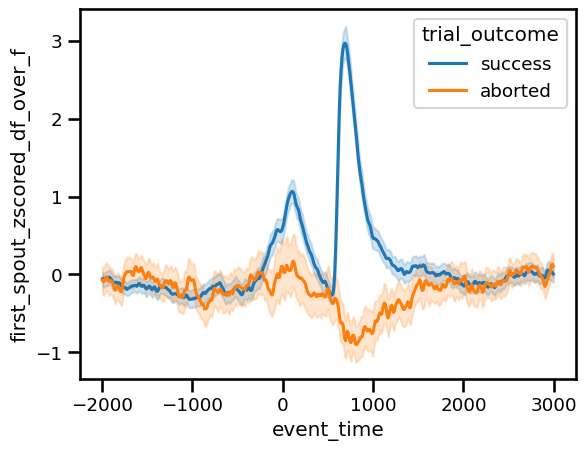

In [161]:
sns.lineplot(df2, x='event_time', y=v, hue='trial_outcome')

In [ ]:
plot_group_average(

In [162]:
df2.groupby(['animal_id','event_time']).count()

index  session_id  trial_nb  \
animal_id event_time                                
JC317L    -1995         108         108       108   
          -1985         108         108       108   
          -1975         108         108       108   
          -1965         108         108       108   
          -1955         108         108       108   
...                     ...         ...       ...   
kms064     2955         108         108       108   
           2965         108         108       108   
           2975         108         108       108   
           2985         108         108       108   
           2995         108         108       108   

                      first_spout_zscored_df_over_f  trial_outcome  \
animal_id event_time                                                 
JC317L    -1995                                 108            108   
          -1985                                 108            108   
          -1975                                 108            108   
          -1965                                 108            108   
          -1955                                 108            108   
...                                             ...            ...   
kms064     2955                                 108            108   
           2965                                 108            108   
           2975                                 108            108   
           2985                                 108            108   
           2995                                 108            108   

                      expt_datetime  grand_trial_nb  
animal_id event_time                                 
JC317L    -1995                 108             108  
          -1985                 108             108  
          -1975                 108             108  
          -1965                 108             108  
          -1955                 108             108  
...                             ...             ...  
kms064     2955                 108             108  
           2965                 108             108  
           2975                 108             108  
           2985                 108             108  
           2995                 108             108  

[2500 rows x 7 columns]

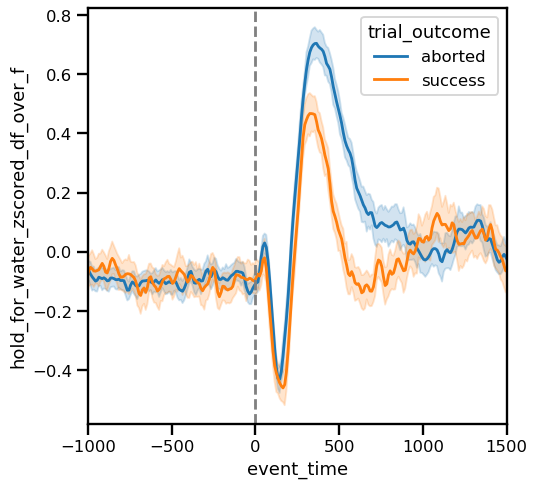

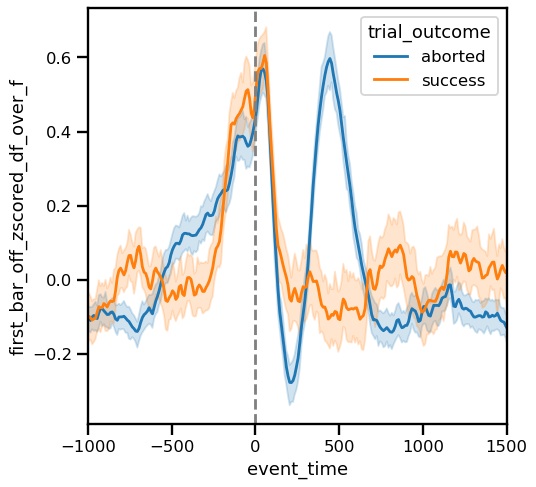

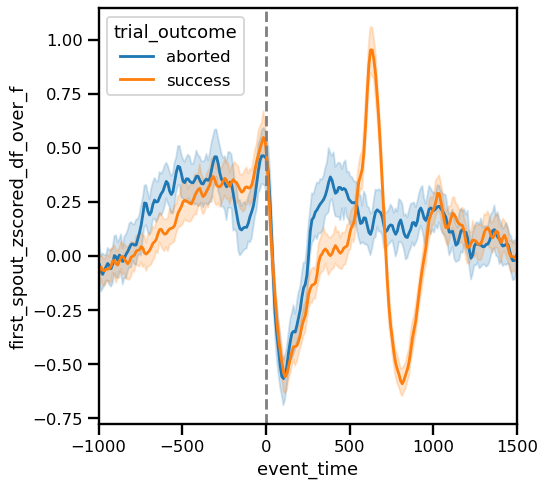

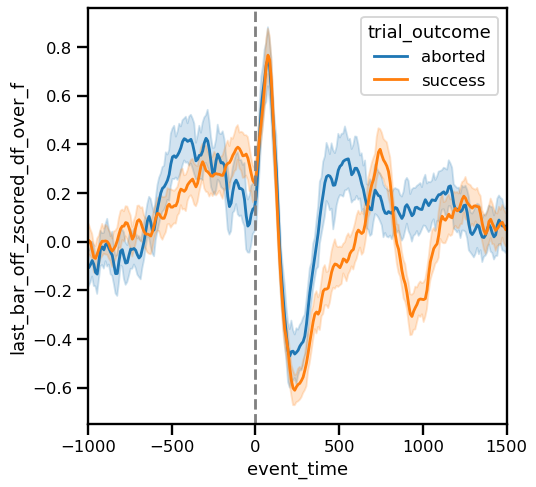

In [129]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    plot_group_average(ds_combined, animal_id, v)

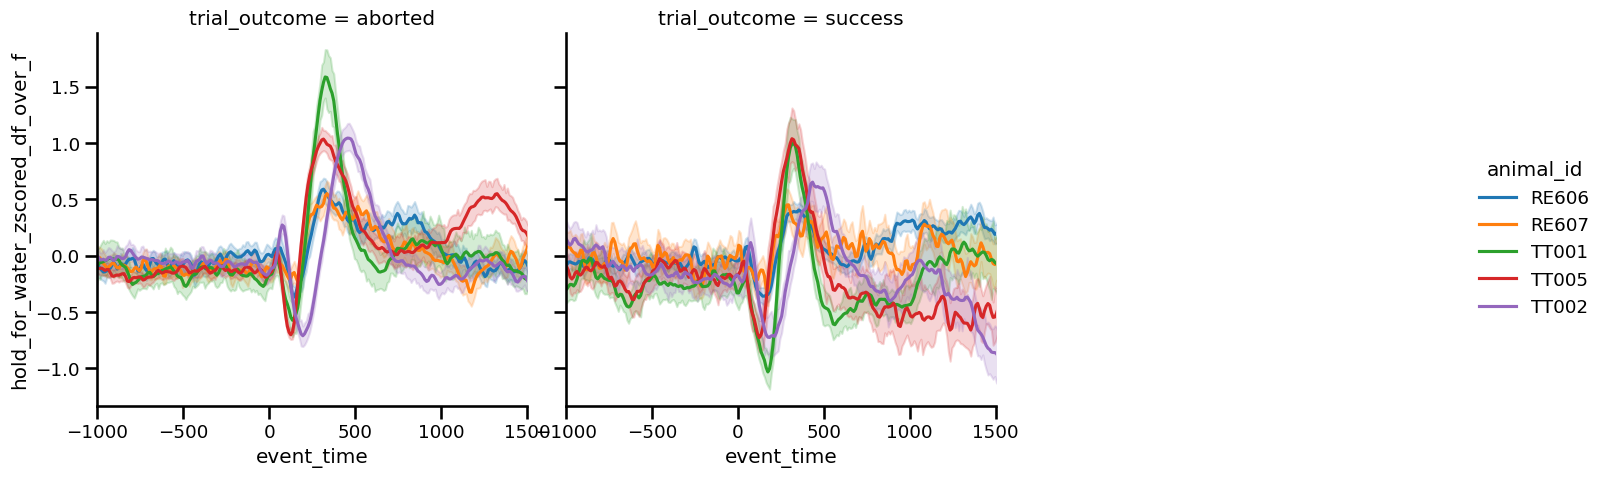

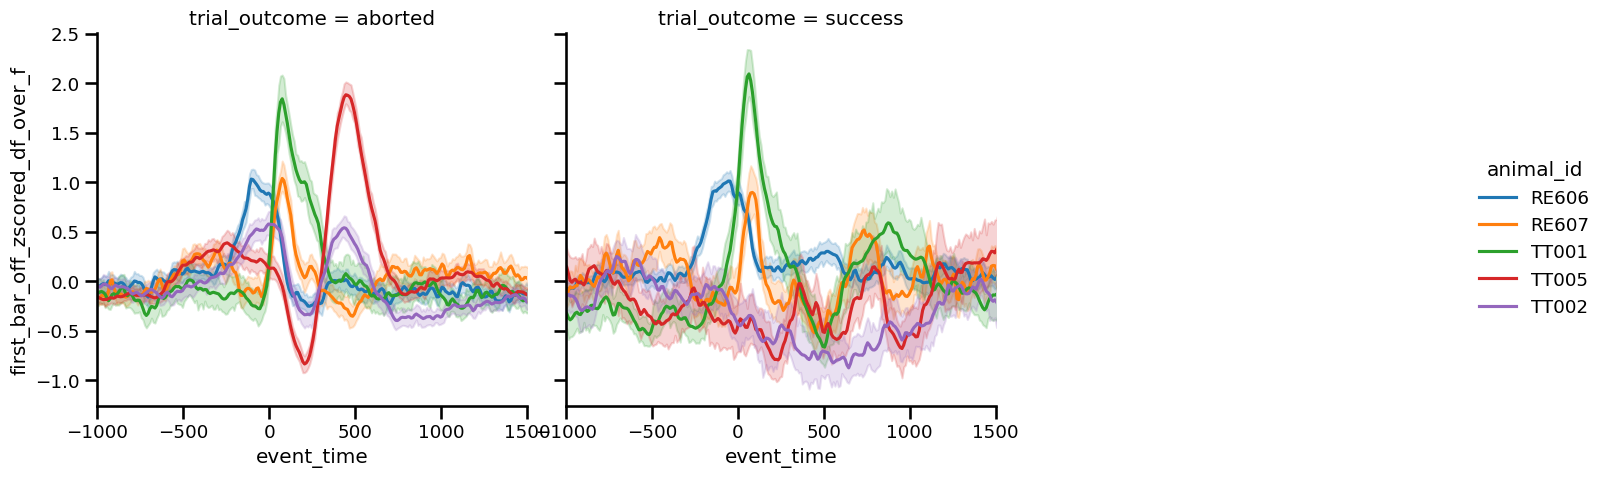

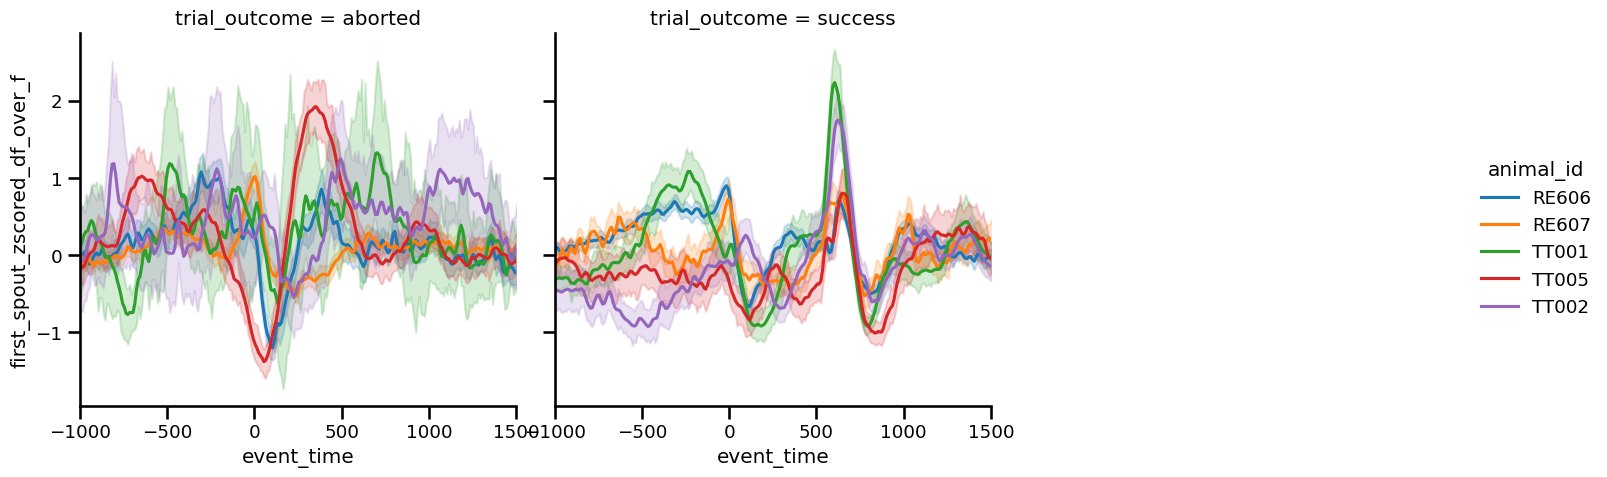

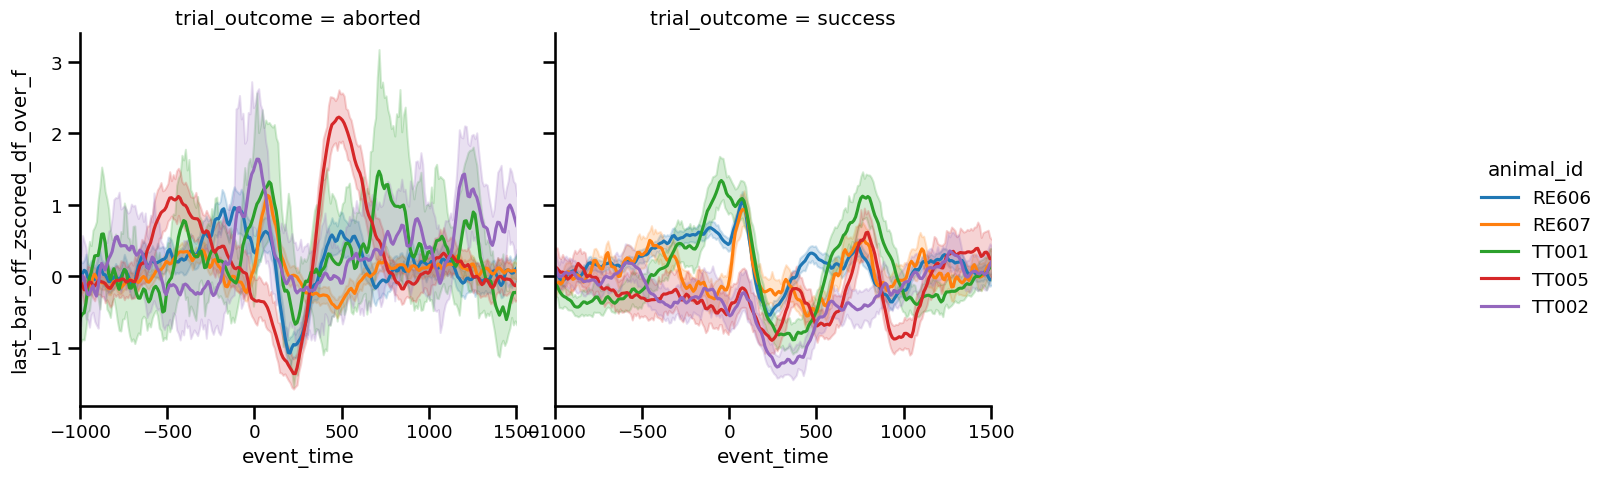

In [130]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    plot_subject_average(ds_combined, animal_id, v)